In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.core.pylabtools import figsize

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal, Exponential, Uniform, Poisson, Empirical

plt.style.use('ggplot')

/Users/laygr/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


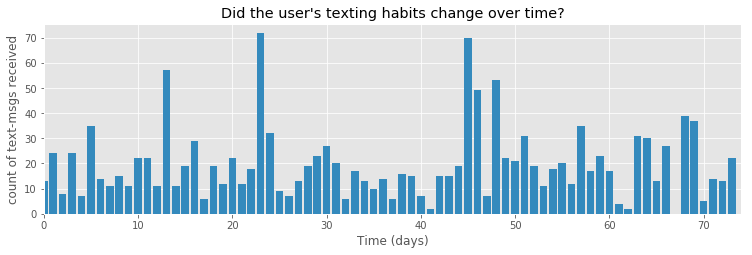

In [2]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [3]:
sess = tf.InteractiveSession()

## Model

In [4]:
alpha = 1.0 / count_data.mean()

# Lambda 1 & 2
rate = tf.ones(n_count_data) * alpha
lambda_1 = Exponential(rate=rate, name="lambda_1")
lambda_2 = Exponential(rate=rate, name="lambda_2")

# Tau
low = tf.zeros(n_count_data)
high = tf.ones(n_count_data) * n_count_data - 1.0
tau = Uniform(low=low, high=high, name="tau")

# Lambda_
idx = np.arange(n_count_data) # Index
conds = tf.greater(tau, idx)
lambda_ = tf.where(conds, lambda_1, lambda_2)

#Observation
observation = Poisson(rate=lambda_, name="obs")

## Inference model

In [5]:
T = 20000  # number of MC samples
l1i = tf.ones((T, n_count_data)) * 20.0
l2i = tf.ones((T, n_count_data)) * 20.0
taui = tf.ones((T, n_count_data)) * 40.0

ql1  = Empirical(tf.get_variable("ql1/params", initializer=l1i))
ql2  = Empirical(tf.get_variable("ql2/params", initializer=l2i))
qtau = Empirical(tf.get_variable("qtau/params", initializer=taui))

## Inference

In [6]:
inference = ed.HMC(
    {lambda_1:ql1, lambda_2:ql2, tau:qtau},
    data={observation: count_data})
inference.run()

/Users/laygr/anaconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


20000/20000 [100%] ██████████████████████████████ Elapsed: 23s | Acceptance Rate: 0.583


## This is where my solution gets suspicious
I'm not sure about the next code.
I take the means of the 74 days in each sample.
Why I have 74 days in each sample? Because of this code above:

    # Lambda_
    idx = np.arange(n_count_data) # Index
    conds = tf.greater(tau, idx)
    lambda_ = tf.where(conds, lambda_1, lambda_2)

How else could I generate the lambdas? Maybe replacing `idx` by a `tf.placeholder`?

In [7]:
ql1_sample = ql1.sample(10000)
ql2_sample = ql2.sample(10000)
qtau_sample = qtau.sample(10000)

ql1_samples = ql1_sample.eval().mean(axis=1)
ql2_samples = ql2_sample.eval().mean(axis=1)
qtau_samples = qtau_sample.eval().mean(axis=1)

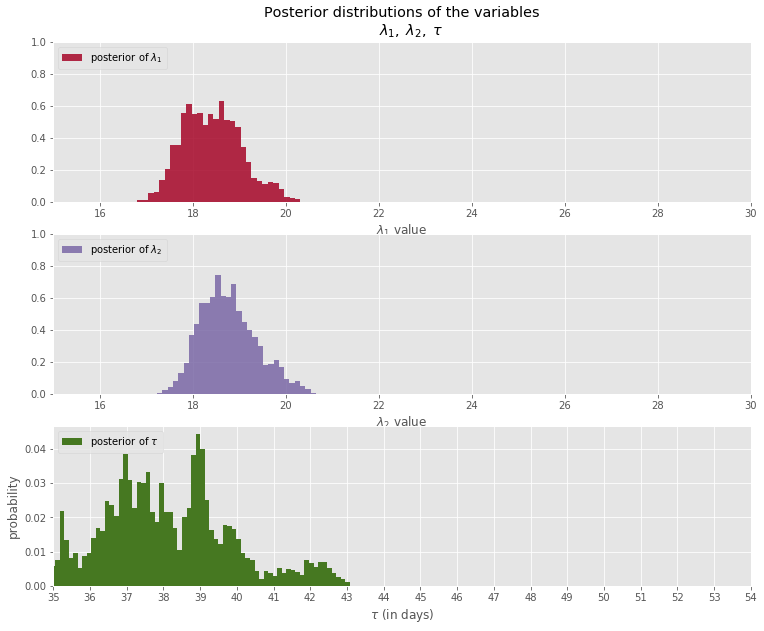

In [8]:
figsize(12.5, 10)

#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(ql1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(ql2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / qtau_samples.shape[0] * np.ones_like(qtau_samples)
plt.hist(qtau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
#plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

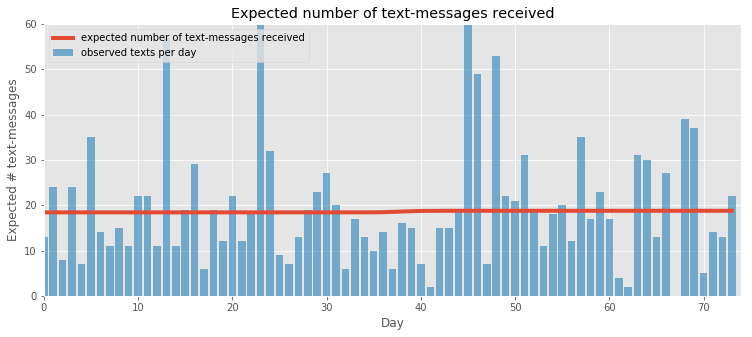

In [9]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = qtau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < qtau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (ql1_samples[ix].sum()
                                   + ql2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");